# Summary

A method for estimating, or anticipating, the results of a physical build from simulation data is needed. The approach proposed uses machine learning to connect these two data streams as the metaphorical glue, as shown in the included figure,

<img src="figs/modeling framework.png" alt="ML model to join experimental and simulation results">

This figure shows two models. The top models simulated input (build parameters) to simulated output (properties), that is, $\hat{y}_\text{sim} = f({\bf X})$. The lower models experimental input (build parameters) to experimental output (properties), $\hat{y}_\text{expt} = g({\bf X})$. In general, and for various reasons ranging from incomplete simulation physics to imperfect knowledge of the experimental conditions, $\hat{y}_\text{sim} \neq \hat{y}_\text{expt}$.

## Hypothesis

Property estimates from simulation vary systematically with experimental property measurements, that is, a functional relationship exists between $\hat{y}_\text{sim}$ and $\hat{y}_\text{expt}$, $\hat{y}^\prime_\text{expt} = h(\hat{y}_\text{sim})$. The functional form of this correlation is not known *a priori*. A model to estimate this functional relationship can range from a univariate regression to a complex point estimation ML model.

## Approach

1. $\hat{y}_\text{expt}$ is fit using a random forest network (RFN) with bootstrap aggregating (bagging).
2. $\hat{y}_\text{sim}$ is fit using an RFN with bagging.
3. $\hat{y}^\prime_\text{expt}$ is fit using **regression**.

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt

# Structures/Function Definitions

In [44]:
def is_array_like(vec):
    return (hasattr(vec, '__iter__') and not isinstance(vec, str))

class Data:
    def __init__(self):
        self._filename = None
        self._dataframe = pd.DataFrame()
        self._inputs = None
        self._outputs = None
    
    @property
    def filename(self):
        return self._filename
    
    @property
    def dataframe(self):
        return self._dataframe
    
    def reset_input_columns(self):
        self._inputs = None
    
    def get_input_columns(self):
        if self._inputs is None:
            return self.dataframe
        return self.dataframe[self._inputs]
    
    def set_input_columns(self, key=None, reset=True):
        """
        Set which columns are the input columns.
        
        :param key (int, str, or list of either): If an int, or a list of int, specifies
            the column index/indices. If a string, list of stings, these refer to column names.
        :returns: This object.
        """
        if reset:
            self._inputs = []
        # inputs are being set, make sure it is a list.
        if self._inputs is None:
            self._inputs = []
        if key is None:
            # by default, all remaining entries are inputs.
            if self._outputs is None:
                self._inputs = self._dataframe.columns.to_list()
            else:
                self._inputs = list(set(self._dataframe.columns.to_list()) -
                                    set(self.get_output_columns()))
        elif isinstance(key, (list, np.ndarray, range)):
            # if a list, add one-at-a-time
            for k in key:
                self.set_input_columns(k, reset=False)
        else:
            # if an int, add that column name by its index, otherwise, add the index
            if isinstance(key, int):
                self._inputs.append(self._dataframe.columns.to_list()[key])
            else:
                if key not in self._dataframe:
                    raise KeyError(f"{key} is not a column name in {self.__name__}.")
                self._inputs.append(key)
        return self
    
    def reset_output_columns(self):
        self._outputs = None
    
    def get_output_columns(self):
        if self._outputs is None:
            return self.dataframe
        return self.dataframe[self._outputs]
    
    def set_output_columns(self, key=None, reset=True):
        """
        Set which columns are the output columns.
        
        :param key (int, str, or list of either): If an int, or a list of int, specifies
            the column index/indices. If a string, list of stings, these refer to column names.
        :returns: This object.
        """
        if reset:
            self._outputs = []
        # outputs are being set, make sure it is a list.
        if self._outputs is None:
            self._outputs = []
        if key is None:
            # by default, all remaining entries are outputs.
            if self._inputs is None:
                self._outputs = self._dataframe.columns.to_list()
            else:
                self._outputs = list(set(self._dataframe.columns.to_list()) -
                                     set(self.get_input_columns()))
        elif isinstance(key, (list, np.ndarray, range)):
            # if a list, add one-at-a-time
            for k in key:
                self.set_output_columns(k, reset=False)
        else:
            # if an int, add that column name by its index, otherwise, add the index
            if isinstance(key, int):
                self._outputs.append(self._dataframe.columns.to_list()[key])
            else:
                if key not in self._dataframe:
                    raise KeyError(f"{key} is not a column name in {self.__name__}.")
                self._outputs.append(key)
        return self
        
    def read_excel(self, filename, *args, **kwds):
        self._filename = filename
        self._dataframe = pd.read_excel(filename, *args, **kwds)
        return self

In [297]:
class Model:
    def __init__(self, estimator, input_labels=None, output_label=None):
        self._X = None
        self._y = None
        self._score = None
        self._inputLabels = input_labels
        self._outputLabel = output_label
        self.estimator = estimator
        
    @property
    def labels(self):
        return {"input": self._inputLabels, "output": self._outputLabel}
    
    def fit(self, X, y, **kwds):
        self._X = np.asarray(X)
        self._y = np.asarray(y)
        # fit estimator
        self.estimator.fit(X, y)
        # error estimation
        opts = dict()
        opts['scoring'] = kwds.get('scoring', ['r2', 'neg_mean_squared_error'])
        opts['n_jobs'] = kwds.get('n_jobs', -1)
        opts['verbose'] = kwds.get('verbose', 0)
        if 'cv' in kwds:
            opts['cv'] = kwds['cv']
        self._score = cross_validate(self.estimator, X, y, **opts)
        # done, allow functions to be daisy-chained
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)

In [82]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)

# Read data

## Simulation data

In [52]:
simulation = Data()\
    .read_excel("data/simulation data plan_complete.xlsx",
                skiprows=2,
                usecols=range(16),
                index_col=0)\
    .set_input_columns(range(5))\
    .set_input_columns(range(12, 15), reset=False)\
    .set_output_columns()

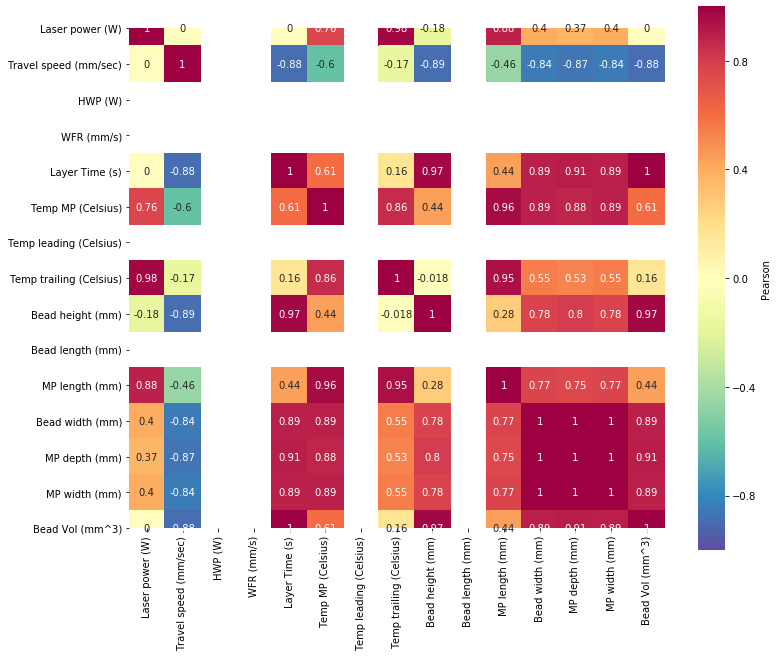

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10));
sns.heatmap(simulation.dataframe[simulation._inputs + simulation._outputs].corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

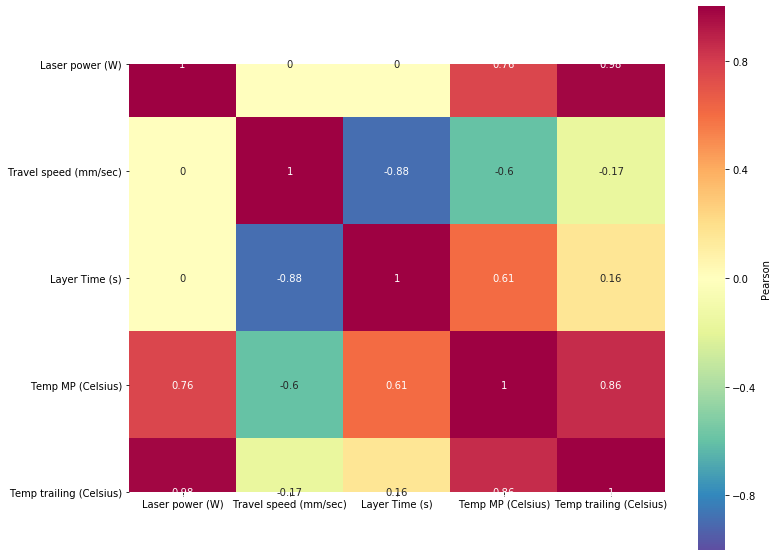

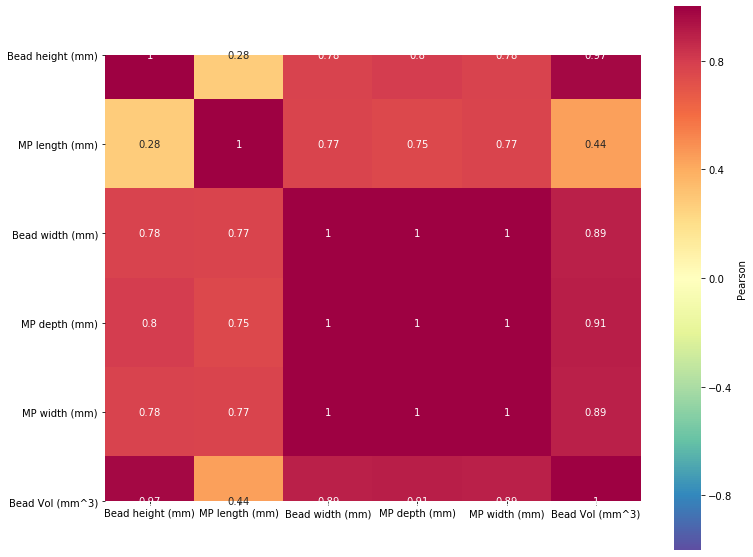

In [54]:
# drop degenerate data
simulation.set_input_columns(
    simulation.get_input_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(simulation.get_input_columns().corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

simulation.set_output_columns(
    simulation.get_output_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(simulation.get_output_columns().corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

## Experimental data

In [108]:
experimental = Data().read_excel("data/qualitymade-20200423.xlsx", index_col=0)

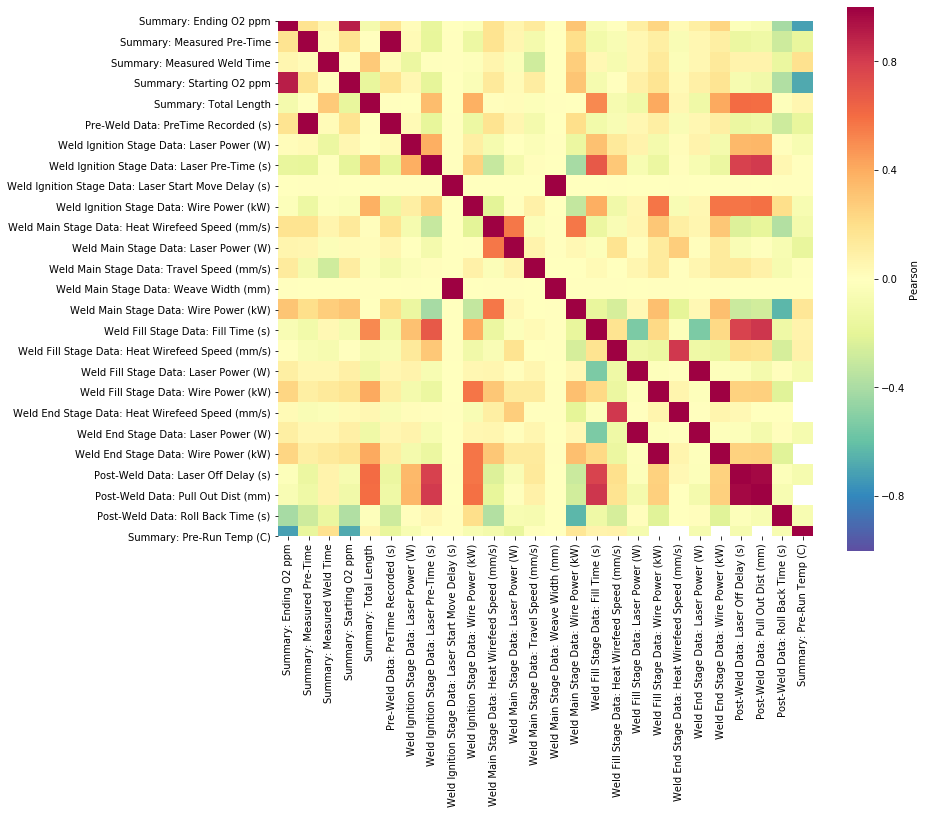

In [123]:
columns = [col for col in experimental.dataframe.columns.to_list()
           if ((col.startswith('Summary:') or
                col.startswith('Pre-Weld Data:') or
                col.startswith('Weld Ignition Stage Data:') or
                col.startswith('Weld Main Stage Data:') or
                col.startswith('Weld Fill Stage Data:') or
                col.startswith('Weld End Stage Data:') or
                col.startswith('Post-Weld Data:')) and not
               (col.endswith('Program') or
                col.endswith('(Hz)')))]

experimental.set_input_columns(columns)
experimental.set_input_columns(
    experimental.get_input_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(experimental.get_input_columns().corr('pearson'),
            ax=ax, square=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

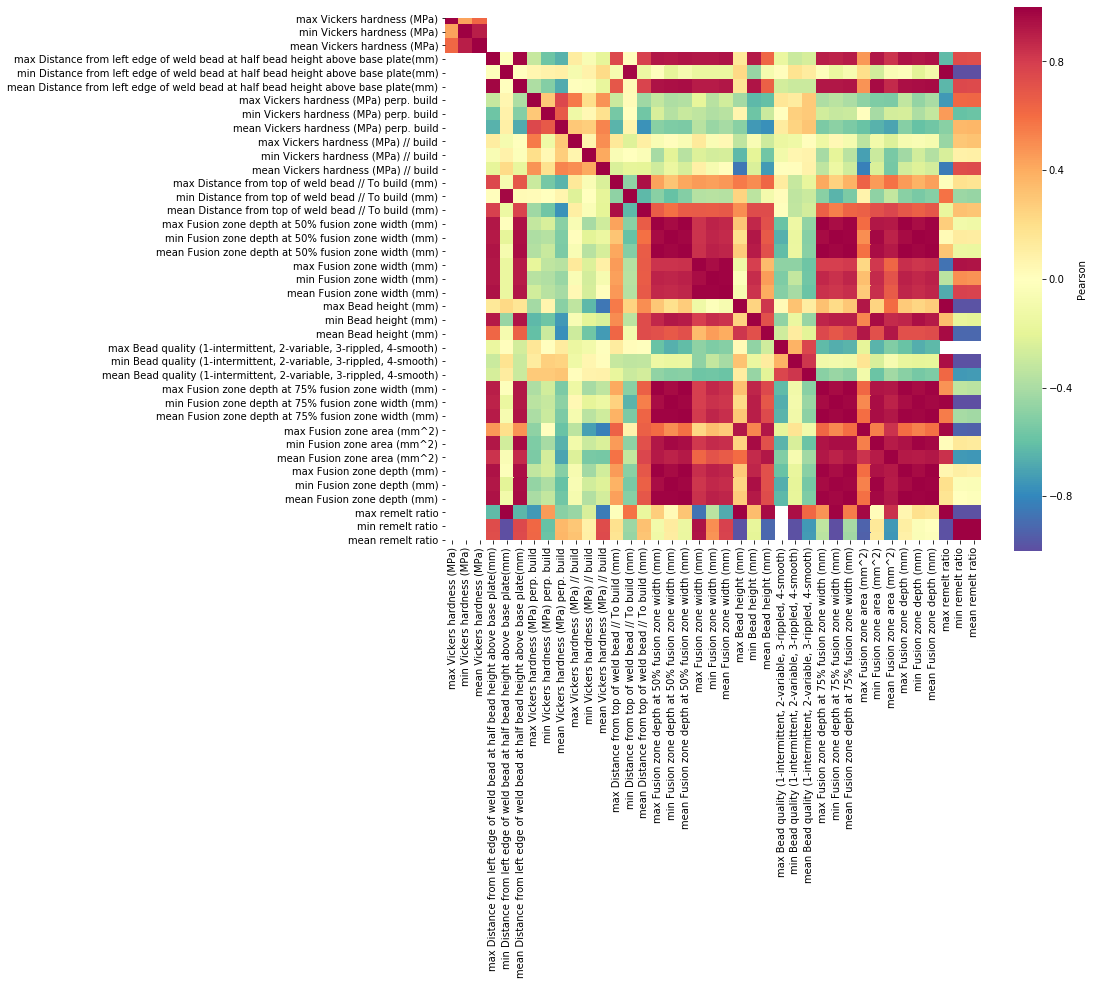

In [111]:
columns = [col for col in experimental.dataframe.columns.to_list()
           if ((col.startswith('mean') or
                col.startswith('min') or
                col.startswith('max')) and
               not col.endswith('Notes'))]

experimental.set_output_columns(columns)
experimental.set_output_columns(
    experimental.get_output_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(experimental.get_output_columns().corr('pearson'),
            ax=ax, square=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

# Build $\hat{y}_\text{expt}$ model

### Random Forest Imputation

Build a series of models to estimate missing values. Set each column, in turn as the target column:

1. Identify rows in the target column that are not NaN. Keep these rows.
2. Identify those columns fully populated in those rows.
3. Fit a model to predict target.
4. Predict missing target values.

In [227]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, LeaveOneOut

def as_dataframe(obj, prefix='x'):
    if not isinstance(obj, (pd.Series, pd.DataFrame)):
        obj = np.asarray(obj)
        try:
            nx, ny = obj.shape
            return pd.DataFrame(obj, columns=[f'{prefix}{i}' for i in range(nx)])
        except ValueError:
            return pd.Series(obj, name=f'{prefix}1').to_frame()
    else:
        try:
            # converting Series to DataFrame
            return obj.to_frame()
        except AttributeError:
            # object is a DataFrame
            return obj

data = experimental.dataframe[experimental._inputs + experimental._outputs]
filled = data.copy()

for targetKey in data.columns.to_list():
    # rows that are not NaN in the target
    target = data[targetKey]
    isnanIndex = np.where(np.isnan(target))[0]
    labelIndex = np.where(~np.isnan(target))[0]

    # model data: features that are not NaN where label is not NaN
    df = data.iloc[labelIndex, :].dropna(axis=1)
    featureKeys = [col for col in df.columns.to_list() if col != targetKey]
    modelData = data[featureKeys + [targetKey]]

    # iterate over missing value
    print(f"Predicting {targetKey}")
    start = time.time()
    for i in isnanIndex:
        # get the subset of feature columns that are not NaN
        df = modelData.iloc[i, :].to_frame().transpose().dropna(axis=1)
        columns = df.columns.to_list()
        if df.shape[1] == 0:
            continue
        # set the feature and label data
        X = modelData[columns].iloc[labelIndex, :].values
        y = modelData.iloc[labelIndex, -1].values
        # fit the model
        model = Model(RandomForestRegressor(n_estimators=300,
                                            criterion="mse",
                                            max_features=0.8)).fit(X, y, cv=LeaveOneOut())
        # use the valid feature values
        x = modelData[columns].iloc[i, :].values[np.newaxis, :]
        # predict the y-value
        ypred = model.predict(x)[0]
        # use the score to esimate the error
        score = model._score['test_neg_mean_squared_error']
        rmse = np.sqrt(-np.mean(score))
        error = np.random.normal(scale=rmse)
        # insert the value + error
        filled[targetKey][i] = ypred + error
    elapsed = time.time() - start
    print(f"Elapsed time filling {targetKey}: {elapsed:.03f} s")

Predicting Summary: Ending O2 ppm
Elapsed time filling Summary: Ending O2 ppm: 0.197 s
Predicting Summary: Measured Pre-Time
Elapsed time filling Summary: Measured Pre-Time: 0.179 s
Predicting Summary: Measured Weld Time
Elapsed time filling Summary: Measured Weld Time: 0.185 s
Predicting Summary: Starting O2 ppm
Elapsed time filling Summary: Starting O2 ppm: 0.242 s
Predicting Summary: Total Length
Elapsed time filling Summary: Total Length: 0.212 s
Predicting Pre-Weld Data: PreTime Recorded (s)
Elapsed time filling Pre-Weld Data: PreTime Recorded (s): 0.231 s
Predicting Weld Ignition Stage Data: Laser Power (W)
Elapsed time filling Weld Ignition Stage Data: Laser Power (W): 0.183 s
Predicting Weld Ignition Stage Data: Laser Pre-Time (s)
Elapsed time filling Weld Ignition Stage Data: Laser Pre-Time (s): 0.180 s
Predicting Weld Ignition Stage Data: Laser Start Move Delay (s)
Elapsed time filling Weld Ignition Stage Data: Laser Start Move Delay (s): 0.182 s
Predicting Weld Ignition Stag

#### Compare the imputed dataset with the original dataset

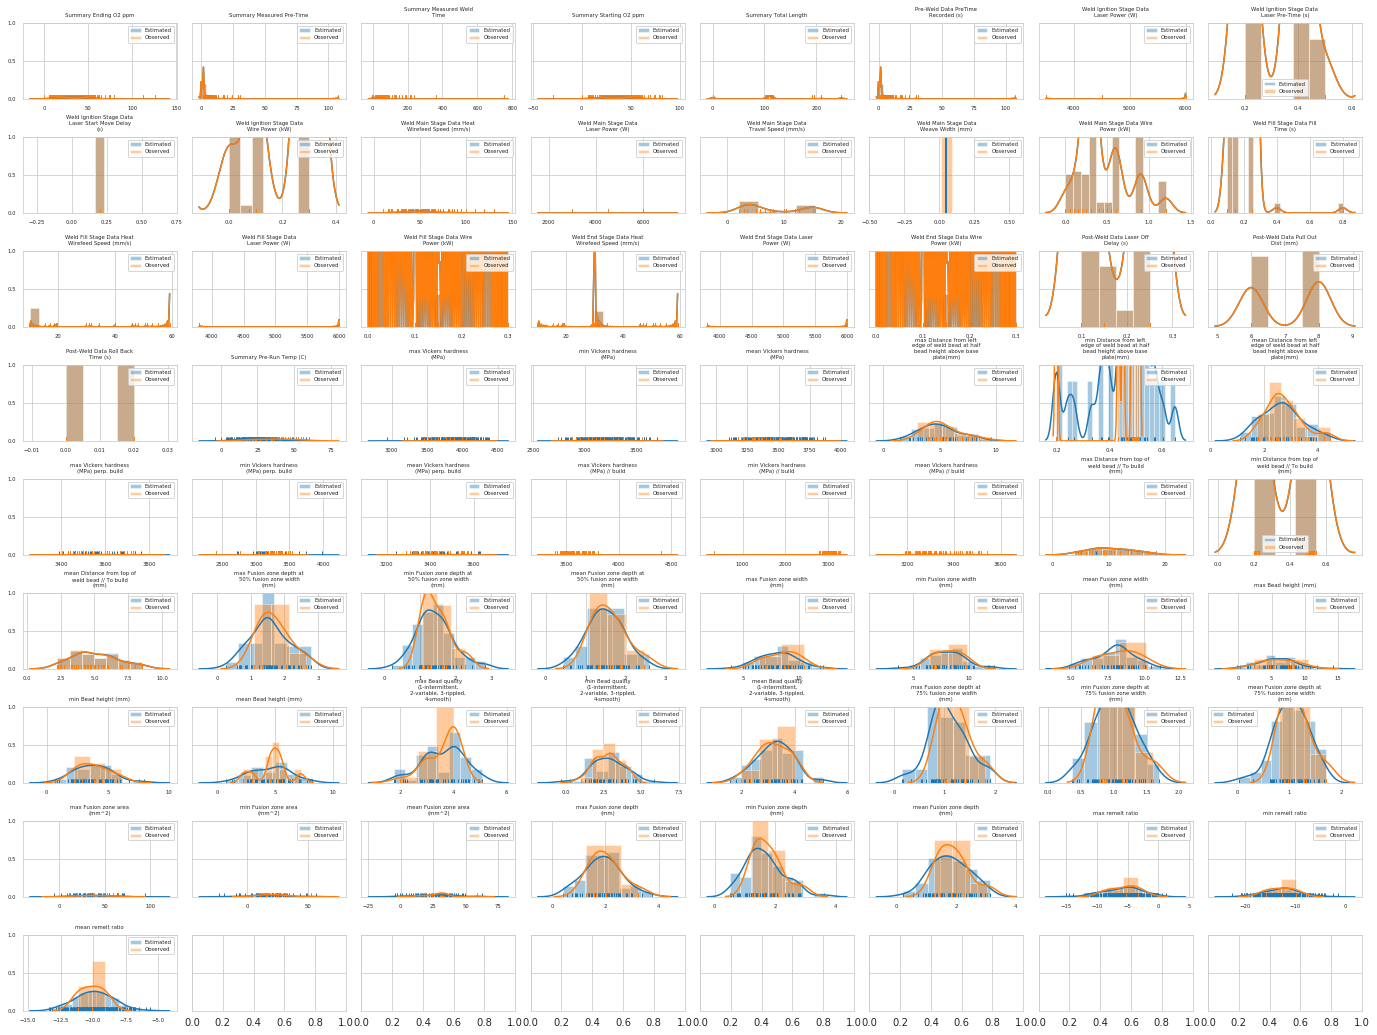

In [272]:
nx, ny = (9, 8)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nx, ny, sharey=True, figsize=(24, 14))
    axes = axes.ravel()

    fontsize = 48/max(nx, ny)
    for ax, col in zip(axes, filled.columns):
        sns.distplot(filled[col].dropna(), rug=True, label="Estimated", ax=ax);
        sns.distplot(experimental.dataframe[col].dropna(), rug=True, label="Observed", ax=ax);
        # set title, splitting column name at 24 characters/line
        title = col
        lines = [line.strip() for line in title.split(':')]
        rows = []
        for line in lines:
            for word in line.split():
                if not rows:
                    rows.append(word)
                elif len(word) + len(rows[-1]) > 24:
                    rows.append(word)
                else:
                    rows[-1] = ' '.join((rows[-1], word))
        ax.set_title('\n'.join(rows));

        ax.legend(fontsize=fontsize);
        ax.set_ylim(0, 1);
        ax.set_xlabel("");
        for label in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)

fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5/np.sqrt(nx), wspace=0.1)
fig.savefig("figs/rfn-imputation.pdf", bbox_inches="tight")

#### Save the imputed dataset to avoid future recalculation (until the model is updated).

In [275]:
filled.to_excel("data/rfn-imputed-qualitymade-20200423.xlsx")

## Fit Experimental Data

### Use filled data from RFN imputation

In [298]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))
targetKeys = list(set(experimental._outputs).intersection(set(filled.columns.to_list())))

df = filled[featureKeys + targetKeys].dropna()

X = df[featureKeys].values

experimentalModels = dict()
for key in df:
    print(f"Fitting {key}")
    y = df[key].values
    model = Model(RandomForestRegressor(n_estimators=300,
                                        criterion="mse",
                                        max_features=0.8),
                  input_labels=featureKeys,
                  output_label=key).fit(X, y, cv=5)
    experimentalModels[key] = model

Fitting Post-Weld Data: Laser Off Delay (s)
Fitting Weld Main Stage Data: Heat Wirefeed Speed (mm/s)
Fitting Summary: Ending O2 ppm
Fitting Post-Weld Data: Pull Out Dist (mm)
Fitting Weld Main Stage Data: Laser Power (W)
Fitting Weld End Stage Data: Laser Power (W)
Fitting Weld Main Stage Data: Wire Power (kW)
Fitting Weld End Stage Data: Heat Wirefeed Speed (mm/s)
Fitting Weld Fill Stage Data: Heat Wirefeed Speed (mm/s)
Fitting Summary: Total Length
Fitting Summary: Measured Weld Time
Fitting Weld Ignition Stage Data: Laser Pre-Time (s)
Fitting Weld Fill Stage Data: Wire Power (kW)
Fitting Weld Ignition Stage Data: Wire Power (kW)
Fitting Weld Ignition Stage Data: Laser Power (W)
Fitting Weld Ignition Stage Data: Laser Start Move Delay (s)
Fitting Pre-Weld Data: PreTime Recorded (s)
Fitting Summary: Measured Pre-Time
Fitting Weld End Stage Data: Wire Power (kW)
Fitting Weld Fill Stage Data: Laser Power (W)
Fitting Weld Fill Stage Data: Fill Time (s)
Fitting Summary: Starting O2 ppm
Fi

/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempting to set identical left == right == 6000.0 results in singular transformations; automatically expanding.
  
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Attempting to set identical bottom == top == 6000.0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempting to set identical left == right == 10.0 results in singular transformations; automatically expanding.
  
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Attempting to set identical bottom == top == 10.0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14

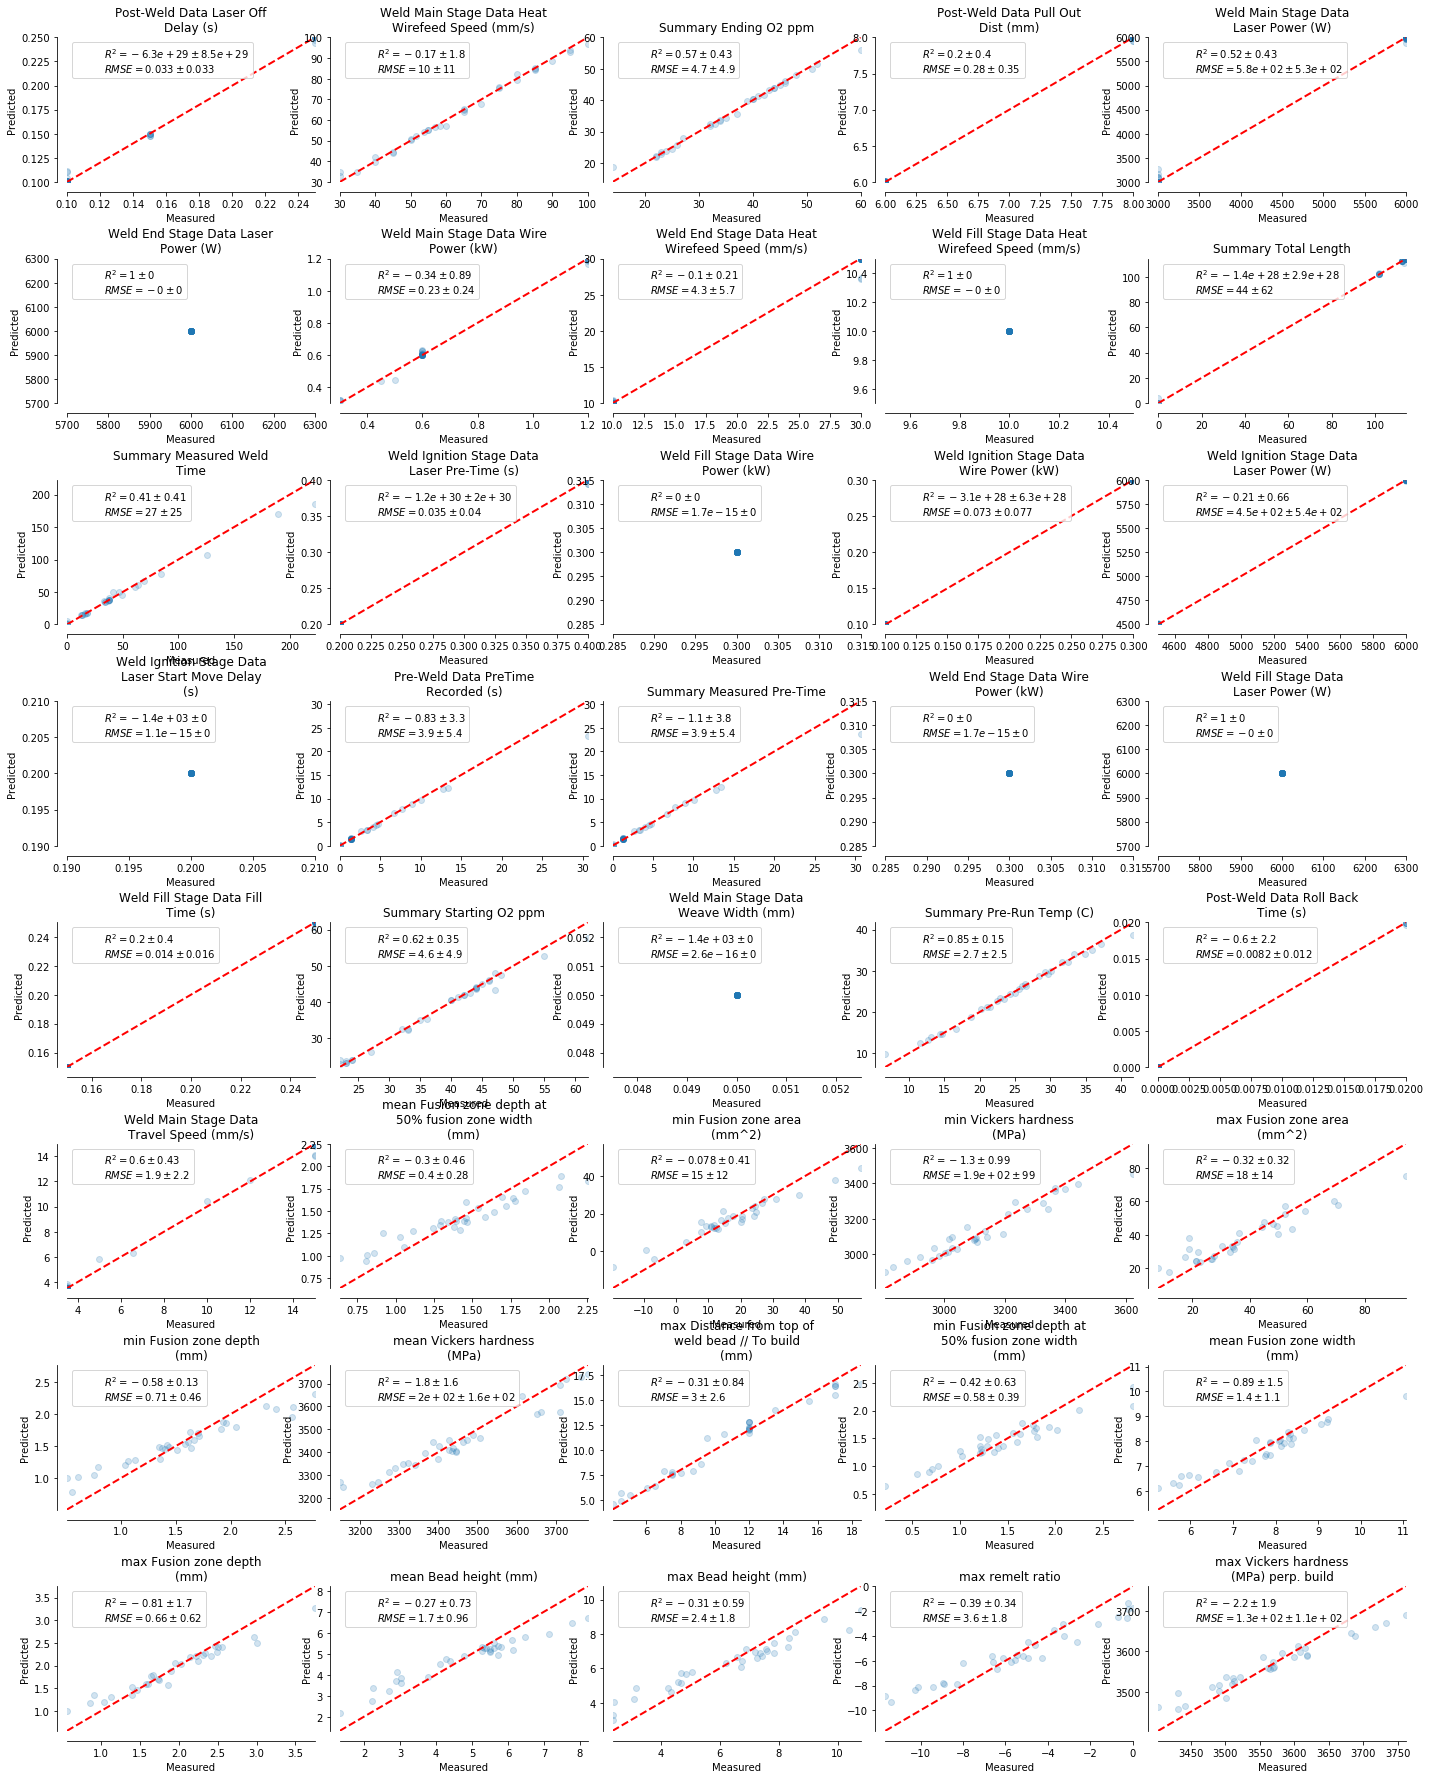

In [288]:
nx, ny = (8, 5)

fig, axes = plt.subplots(nx, ny, figsize=(24, 24))
axes = axes.ravel()

# fontsize = 48/max(nx, ny)
for ax, (name, model) in zip(axes, experimentalModels.items()):
    y_true = model._y
    y_pred = model.predict(model._X)
    scores = model._score
    scores = (r'$R^2={:.2g} \pm {:.2g}$' + '\n'
              r'$RMSE={:.2g} \pm {:.2g}$')\
        .format(np.mean(scores['test_r2']),
                np.std(scores['test_r2']),
                np.sqrt(-np.mean(scores['test_neg_mean_squared_error'])),
                np.sqrt(np.std(scores['test_neg_mean_squared_error'])))
    
    # set title, splitting column name at 24 characters/line
    title = name
    lines = [line.strip() for line in title.split(':')]
    rows = []
    for line in lines:
        for word in line.split():
            if not rows:
                rows.append(word)
            elif len(word) + len(rows[-1]) > 24:
                rows.append(word)
            else:
                rows[-1] = ' '.join((rows[-1], word))
    title = '\n'.join(rows);
    
    plot_regression_results(ax, y_true, y_pred, title, scores)

#     ax.legend(fontsize=fontsize);
#     ax.set_ylim(0, 1);
#     ax.set_xlabel("");
#     for label in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                   ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(fontsize)

fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5/np.sqrt(nx), wspace=0.1);
fig.savefig("figs/rfn-impute-experimental-fits.pdf", bbox_inches='tight');

### Use a simple imputer to fill in missing data

# Build $\hat{y}_\text{sim}$ model

In [299]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, LeaveOneOut

X = simulation.get_input_columns().values

df = simulation.get_output_columns()
simulationModels = dict()
for key in df:
    print(f"Fitting {key}")
    y = df[key].values
    model = Model(RandomForestRegressor(n_estimators=100,
                                        criterion="mse",
                                        max_features=0.8),
                  input_labels=simulation._inputs,
                  output_label=key).fit(X, y, cv=LeaveOneOut())
    simulationModels[key] = model

Fitting Bead height (mm)
Fitting MP length (mm)
Fitting Bead width (mm)
Fitting MP depth (mm)
Fitting MP width (mm)
Fitting Bead Vol (mm^3)


/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Use

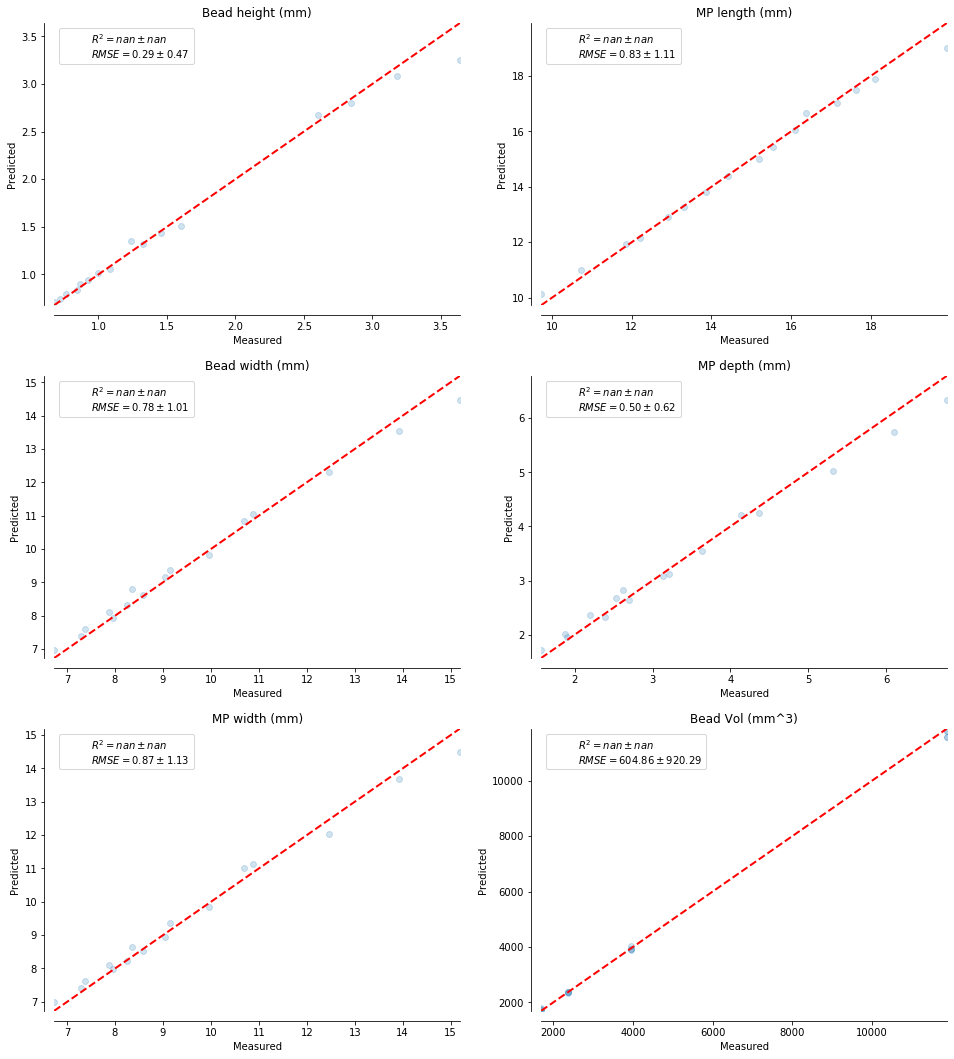

In [300]:
fig, ax = plt.subplots(3, 2, figsize=(16, 14))
ax = ax.ravel()

for ax, (name, model) in zip(ax, simulationModels.items()):
    y_true = model._y
    y_pred = model.predict(model._X)
    scores = model._score
    scores = (r'$R^2={:.2f} \pm {:.2f}$' + '\n'
              r'$RMSE={:.2f} \pm {:.2f}$')\
        .format(np.nanmean(scores['test_r2']),
                np.nanstd(scores['test_r2']),
                np.sqrt(-np.mean(scores['test_neg_mean_squared_error'])),
                np.sqrt(np.std(scores['test_neg_mean_squared_error'])))
    plot_regression_results(ax, y_true, y_pred, name, scores)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)

# Estimate $\hat{y}_\text{expt}$ and $\hat{y}_\text{sim}$ from random inputs

The two models are fit over different phase spaces, $A$ and $B$, forming a joint phase space, $P = A \cup B$. However, these models may be compared if there exists an intersection in those phase spaces, $C = A \cap B$. The difference in their phase spaces, $D_A = A - B$ and $D_B = B - A$, act as a source of uncontrolled error.

Therefore, to develop a model that maps between the $\hat{y}_\text{expt}$ and $\hat{y}_\text{sim}$, uniformly sample from multivariate distributions in $C$, $D_A$, and $D_B$. The sample vector in the phase space of the experimental model (model A) is $Q_A = C_A + U(D_A)$ and in the phase space of the simulation model (model B) is $Q_B = C_B + U(D_B)$ under the condition that $C_A = C_B = U(C)$. $U(\cdot)$ indicates randomly sampling from a uniform distribution.

1. Uniformly sample data in the range of all input parameters. For variables common to both, $C$, there are two options:
    1. The domain is the intersection of the domains of the experimental and simulation, i.e. $\max(\min A, \min B)$ to $\min(\max A, \max B)$.
    2. The domain is the union of the experimental and simulation domains, i.e. $\min(\min A, \min B)$ to $\max(\max A, \max B)$.
2. Predict estimates.
3. Examine estimates to intuit functional relationship.

In [321]:
outputs = pd.DataFrame(np.zeros((len(experimentalModels), len(simulationModels)),
                                dtype=bool),
                       index=list(experimentalModels),
                       columns=list(simulationModels),
                       dtype=bool)

# map between CMU/CSM characterization naming convention and CMU modeling naming convention
outputs.loc['mean Bead height (mm)', 'Bead height (mm)'] = True
outputs.loc['mean Fusion zone width (mm)', 'Bead width (mm)'] = True
outputs.loc['mean Fusion zone depth (mm)', 'MP depth (mm)'] = True
outputs.loc['mean Fusion zone width (mm)', 'MP width (mm)'] = True

In [337]:
outputs[outputs].dropna(how="all").dropna(axis=1, how="all")

,Bead height (mm),Bead width (mm),MP depth (mm),MP width (mm)
mean Fusion zone width (mm),NaN,1.0,NaN,1.0
mean Bead height (mm),1.0,NaN,NaN,NaN
mean Fusion zone depth (mm),NaN,NaN,1.0,NaN


In [347]:
index = set(sum([m.labels["input"] for m in experimentalModels.values()], []))
columns = set(sum([m.labels["input"] for m in simulationModels.values()], []))

inputs = pd.DataFrame(np.zeros((len(index), len(columns)), dtype=bool),
                      index=index, columns=columns, dtype=bool)

# map between Lincoln Electric naming convention and CMU modeling naming convention
inputs.loc["Weld Main Stage Data: Laser Power (W)", "Laser power (W)"] = True
inputs.loc["Summary: Measured Weld Time", "Layer Time (s)"] = True
inputs.loc["Weld Main Stage Data: Travel Speed (mm/s)", "Travel speed (mm/sec)"] = True

In [348]:
inputs[inputs].dropna(how="all").dropna(axis=1, how="all")

,Laser power (W),Layer Time (s),Travel speed (mm/sec)
Weld Main Stage Data: Laser Power (W),1.0,NaN,NaN
Summary: Measured Weld Time,NaN,1.0,NaN
Weld Main Stage Data: Travel Speed (mm/s),NaN,NaN,1.0


In [353]:
selectionMatrix = inputs.join(outputs, how="outer").fillna(False)
selectionMatrix[selectionMatrix].dropna(how="all").dropna(how="all", axis=1)

,Laser power (W),Layer Time (s),Travel speed (mm/sec),Bead height (mm),Bead width (mm),MP depth (mm),MP width (mm)
Summary: Measured Weld Time,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Weld Main Stage Data: Laser Power (W),1.0,NaN,NaN,NaN,NaN,NaN,NaN
Weld Main Stage Data: Travel Speed (mm/s),NaN,NaN,1.0,NaN,NaN,NaN,NaN
mean Bead height (mm),NaN,NaN,NaN,1.0,NaN,NaN,NaN
mean Fusion zone depth (mm),NaN,NaN,NaN,NaN,NaN,1.0,NaN
mean Fusion zone width (mm),NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [397]:
class PhaseSpace:
    def __init__(self, modelA, modelB, selection, domain="union"):
        self._A = None
        self._B = None
        self._left = None
        self._intersection = None
        self._right = None
        self._keyMap = None
        self._minLeft = None
        self._minIntersection = None
        self._minRight = None
        self._maxLeft = None
        self._maxIntersection = None
        self._maxRight = None
        self._assign(modelA, modelB, selection)
        self._limits(domain)
        
    def _assign(self, modelA, modelB, selection):
        if isinstance(modelA, Model):
            dfA = pd.DataFrame(modelA._X, columns=modelA.labels["input"])
        else:
            dfA = modelA
        if isinstance(modelA, Model):
            dfB = pd.DataFrame(modelB._X, columns=modelB.labels["input"])
        else:
            dfB = modelB
        if not isinstance(modelA, pd.DataFrame):
            raise TypeError("(A) is not a valid PhaseSpace type.")
        if not isinstance(modelB, pd.DataFrame):
            raise TypeError("(B) is not a valid PhaseSpace type.")
        # selection
        if isinstance(selection, pd.DataFrame):
            keyMap = [(selection.index[i], selection.columns[j])
                      for i, j in zip(*np.where(selection))]
        else:
            keyMap = selection
        # row and col are defined by the degree of coincidence between
        # model A, model B and the selection matrix index and columns
        setA = set(dfA.columns.to_list())
        setB = set(dfB.columns.to_list())
        rowSet = set([k[0] for k in keyMap])
        colSet = set([k[1] for k in keyMap])
        row, col = dfA, dfB
        if ((len(setA.intersection(rowSet)) > len(setA.intersection(colSet))) and
            (len(setB.intersection(rowSet)) < len(setB.intersection(colSet)))):
            pass
        elif ((len(setA.intersection(rowSet)) < len(setA.intersection(colSet))) and
              (len(setB.intersection(rowSet)) > len(setB.intersection(colSet)))):
            keyMap = [(k2, k1) for k1, k2 in keyMap]
        else:
            raise ValueError("The selection matrix does not appear to map the two models.")
        # define domain
        self._A = row
        self._B = col
        self._keyMap = keyMap
        
    def _limits(self, domain="union"):
        # START HERE--SPLIT MIN AND MAX TO LEFT, RIGHT, AND INTERSECTION
        A, B = self._A, self._B
        keyMap = self._keyMap
        Amin, Amax = A.min(axis=0, skipna=True), A.max(axis=0, skipna=True)
        Bmin, Bmax = B.min(axis=0, skipna=True), B.max(axis=0, skipna=True)
        if domain.lower() == "union":
            self._min = pd.Series({key: min(Amin[ik], Bmin[jk])
                                   for ik, jk in keyMap
                                   for key in (ik, jk)})
            self._max = pd.Series({key: max(Amax[ik], Bmax[jk])
                                   for ik, jk in keyMap
                                   for key in (ik, jk)})
        elif domain.lower() == "intersection":
            self._min = pd.Series({key: max(Amin[ik], Bmin[jk])
                                   for ik, jk in keyMap
                                   for key in (ik, jk)})
            self._max = pd.Series({key: min(Amax[ik], Bmax[jk])
                                   for ik, jk in keyMap
                                   for key in (ik, jk)})
        
    def gets(self, key):
        if key in self._left:
            return self._left[key]
        elif key in self._right:
            return self._right[key]
        else:
            for k in self._intersection:
                if key in k:
                    return self._intersection[k]
        raise KeyError(f"{key} not found")
        
    def sets(self, row, col, value):
        if col in self._left:
            if isinstance(row, int):
                row = self._left.index.iloc[row]
            self._left.loc[row, col] = value
            return self
        elif col in self._right:
            if isinstance(row, int):
                row = self._right.index.iloc[row]
            self._right.loc[row, col] = value
            return self
        else:
            for k in self._intersection:
                if key in k:
                    if isinstance(row, int):
                        row = self._intersection.index.iloc[row]
                    self._intersection.loc[row, k] = value
                    return self
        raise KeyError(f"({row}, {col}) not found")
    
    @property
    def left(self):
        columns = self._left.columns.to_list() + [k[0] for k in self._intersection.columns.to_list()]
        df = pd.concat((self._left, self._intersection), axis=1)
        df.columns = columns
        return df
    
    @property
    def right(self):
        columns = self._right.columns.to_list() + [k[1] for k in self._intersection.columns.to_list()]
        df = pd.concat((self._right, self._intersection), axis=1)
        df.columns = columns
        return df
    

def random_sample(modelA, modelB, selection, size=1, domain="union"):
    """
    Generates a random sample across the feature domain defined in models A and B.
    
    :param modelA, Model: One trained model.
    :param modelB, Model: The other trained model.
    :selection, pd.DataFrame: A binary matrix that idenfies which keys from modelA
        are semantically equivalent (matched) to keys from modelB.
    :param size, int, tuple: The number of random samples to generate. If an integer,
        then generate `size` number of samples. If a tuple, (nX, nNull), generate
        nNull replicas in the space of the variables not shared between the two
        models.
    :param domain, str: How the matched domains are to be combined. Acceptable values
        are:
            "union"           domain = min(min A, min B), max(max A, max B))
            "intersection"    domain = max(min A, min B), min(max A, max B))
    :returns: List of features, (X_A, X_B)
    :rtype: list of tuples
    """
    dfA = pd.DataFrame(modelA._X, columns=modelA.labels["input"])
    dfB = pd.DataFrame(modelB._X, columns=modelB.labels["input"])
    # row and col are defined by the degree of coincidence between
    # model A, model B and the selection matrix index and columns
    setA = set(dfA.columns.to_list())
    setB = set(dfB.columns.to_list())
    rowSet = set(selection.index)
    colSet = set(selection.columns.to_list())
    if ((len(setA.intersection(rowSet)) > len(setA.intersection(colSet))) and
        (len(setB.intersection(rowSet)) < len(setB.intersection(colSet)))):
        row, col = dfA, dfB
    elif ((len(setA.intersection(rowSet)) < len(setA.intersection(colSet))) and
          (len(setB.intersection(rowSet)) > len(setB.intersection(colSet)))):
        row, col = dfB, dfA
    else:
        raise ValueError("The selection matrix does not appear to map the two models.")
    # define domain
    indexMap = [(selection.index[i], selection.columns[j]) for i, j in zip(*np.where(selection))]
    rowMin, rowMax = row.min(axis=0, skipna=True), row.max(axis=0, skipna=True)
    colMin, colMax = col.min(axis=0, skipna=True), col.max(axis=0, skipna=True)
    if domain.lower() == "union":
        intersectionMin = pd.Series({key: min(rowMin[ik], colMin[jk])
                             for ik, jk in indexMap
                             for key in (ik, jk)})
        intersectionMax = pd.Series({key: max(rowMax[ik], colMax[jk])
                             for ik, jk in indexMap
                             for key in (ik, jk)})
    elif domain.lower() == "intersection":
        intersectionMin = pd.Series({key: max(rowMin[ik], colMin[jk])
                             for ik, jk in indexMap
                             for key in (ik, jk)})
        intersectionMax = pd.Series({key: min(rowMax[ik], colMax[jk])
                             for ik, jk in indexMap
                             for key in (ik, jk)})
    else:
        raise ValueError("Choose 'union' or 'intersection' to define "
                         "the domain of matching features.")
    rowMin = rowMin[[name for name in rowMin.index if (name not in intersectionMin.index)]]
    rowMax = rowMax[[name for name in rowMax.index if (name not in intersectionMax.index)]]
    colMin = colMin[[name for name in colMin.index if (name not in intersectionMin.index)]]
    colMax = colMax[[name for name in colMax.index if (name not in intersectionMax.index)]]
    # sample row
    # sample column

In [398]:
modelA = list(experimentalModels.values())[0]
modelB = list(simulationModels.values())[0]

lo, hi = random_sample(modelA, modelB, selectionMatrix)

In [425]:
df = pd.DataFrame({'a': range(5), 'b': range(5), 'c': range(5)}, index=['u', 'v', 'w', 'x', 'y'])
df

,a,b,c
u,0,0,0
v,1,1,1
w,2,2,2
x,3,3,3
y,4,4,4


In [428]:
df['a']['x']

3

In [420]:
s.index

Index(['a', 'b', 'c'], dtype='object')

In [412]:
s

b    2
c    3
dtype: int64